# Membrane potentials

In [1]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.axislines import Subplot
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
import model_class; reload(model_class)

%matplotlib inline

show_fig = False
save_fig = True
xfactor = 2.6
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
colors = style.colors

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 2 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)


## Mean field model solution:

In [2]:
# %load "../analysis/trans_mean_field.py"
def solve_model(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root

    if jacobian==False:
        jac = False
    else:
        print("Use jacobian")
        jac = model.jacobian
        
    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    if sol["success"]:
        v0  = sol["x"]
        if np.all(v0 < 1./model.t_ref): 
            return v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")
        
#######################################################
# Global boundaries
#######################################################
connection_rule = "fixed_indegree"
weight_rel_sd      = 0.1
model_micro       = model_class.model(connection_rule=connection_rule,
                                           weight_rel_sd=weight_rel_sd) 
v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])

t_int0      = time.time()
rate_mf = solve_model(model_micro, v_guess_0)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

Integration time: 0.06


In [3]:
def prob_V(V_array, mu_i, sd_i, v0_i, model=model_class.model()):
    """Membrane potential probability distribution P(V_m) according to Brunel"""
    from scipy.integrate import quad
    step        = lambda x: 0.5 * (np.sign(x) + 1)  # Heaviside step function
    red         = lambda V: (V - mu_i) / sd_i           # reduced voltage
    P_integrand = lambda u: step(u - red(model.V_r)) * np.exp(u**2) # integrand
    
    Vs = V_array - model.E_L # shift since Brunel's model is using E_L = 0
    
    # Integral boundaries
    lowers  = red(Vs)
    upper  = red(model.theta)
  
    integrals   = np.array([quad(P_integrand, lower, upper)[0] for lower in lowers])

    P_V_array   = 2 * v0_i * model.tau_m / sd_i * np.exp(- (Vs - mu_i)**2 / sd_i**2) * integrals
    
    return step(-Vs + model.theta) * P_V_array

In [15]:
def plot_membrane_potential(path_res_file, rate_mf, 
                            figname="membrane_potential"):
    # Model
    connection_rule = "fixed_indegree"
    weight_rel_sd      = 0.0 # 0.1 for micro
    model           = model_class.model(connection_rule=connection_rule,
                                               weight_rel_sd=weight_rel_sd) 

    # Get voltage data
    with h5py.File(path_res_file, "r") as res_file:
        sim_spec2 = "0"
        res_grp = res_file[sim_spec2]
        # Rates
        rates_mean   = res_grp["rates_mean"][:]
        rates_std    = res_grp["rates_std"][:]
        # Voltage
        dset_times_volt     = res_grp["times_volt"]
        t_min_volt = dset_times_volt.attrs["t_min_volt"]
        t_max_volt = dset_times_volt.attrs["t_max_volt"]
        dt_volt    = dset_times_volt.attrs["dt_volt"]
        volt_histo_means  = res_grp["volt_histo_means"][:]
        V_min       = res_grp.attrs["V_min"]
        V_max       = res_grp.attrs["V_max"]
        n_bins_volt = res_grp.attrs["n_bins_volt"]
        n_neurons_rec_voltage = res_grp.attrs["n_neurons_rec_voltage"][:]

    # Input according to Brunel
    mu_brunel   = model.mu(rate_mf)
    sd_brunel   = model.sd(rate_mf)
    # and with simulated input
    mu_sim      = model.mu(rates_mean)
    sd_sim      = model.sd(rates_mean)
    
    # Voltage: Index of V = E_L
    V_step = (V_max - V_min) / n_bins_volt
    V_array = np.arange(V_min, V_max, V_step)
    V_r_arg = np.argmin(np.abs(V_array - (model.V_r + model.E_L))) # Index of neurons in refractory period
    n_t = (t_max_volt - t_min_volt) / dt_volt # number of time bins
    V_range_plot = [-80, V_max + 1]

    # Figure
    fig = plt.figure()
    fig.set_size_inches(style.figsize[0], style.figsize[1]*1.8) 
    ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    ymax = 0.17 # max height for each population
    # Labels
    marker_sim = "-"
    marker_mf  = "-"
    #ax1.plot([0, 0], [0, 0], marker_sim, color="gray", label="simulated") 
    #ax1.plot([0, 0], [0, 0], marker_mf, color="gray", label="mean field", linewidth=3.0)

    for i, population in enumerate(populations):
        # Remove neurons in refractory period
        with h5py.File(path_res_file, "r") as res_file:
            single_rates = res_file["0/single_rates/" + population][:n_neurons_rec_voltage[i]]
        P_V_data =  volt_histo_means[i].copy()
        P_V_data[V_r_arg] -= np.sum(single_rates) * model.t_ref * n_t

        # Normalization
        norm_factor = n_t * n_neurons_rec_voltage[i] * V_step
        P_V_data_normed = P_V_data / norm_factor
        
        # Theoretical distirbution using Brunel's mu and sd but measured rate v0
        #P_V_theo = prob_V(V_array, mu_sim[i], sd_sim[i], rates_mean[i], model=model)
        P_V_theo = prob_V(V_array, mu_brunel[i], sd_brunel[i], rate_mf[i], model=model)

        # Calculate integral of P_theo(V)
        P_cum = np.sum(P_V_data_normed) * V_step
        P_cum_theo = np.sum(P_V_theo) * V_step
        
        # Adjust histogram for "steps"
        P_V_data_normed = hf.adjust_steps(P_V_data_normed)

        # Plotting
        if reverse_order:
            offset = (n_populations - (i + 1)) * ymax
        else:
            offset = i * ymax
        ax1.plot(V_array, P_V_data_normed + offset, 
                 marker_sim, linewidth=1., color=colors[i], drawstyle="steps")
        ax1.plot(V_array, P_V_theo + offset, marker_mf, linewidth=1.0, color=colors[i])
        ax1.plot(V_range_plot, [offset]*2, "-", color=style.axes_color, linewidth=0.5) # line indicating P = 0

    # Resting potential and treshhold
    #ax1.plot([model.E_L + model.theta]*2, [0, n_populations * ymax], 
    #         "--", linewidth=1.5, color="gray", zorder=0 )#, label="$\\theta$")
    ax1.plot([model.E_L]*2, [0, n_populations * ymax], 
             "-.", linewidth=1, color="gray", alpha=0.5, zorder=0 )#, label="$E_L$")
    
    # Axes label, etc.
    ax1.set_xlabel('Membrane potential $V_m$ / mV')
    ax1.set_ylabel('Probability $P(V)$')
    ax1.set_ylim(0, n_populations * ymax)
    ax1.set_xlim(*V_range_plot)
    ax1.grid(False)
    ax1.legend(loc='best')

    # Create ticks manually
    n_ticks = 4
    ytickmax = ymax - 0.01
    yto           = np.arange(0, ytickmax, ytickmax/n_ticks)
    yt_offset     = np.repeat(np.arange(0,  n_populations * ymax, ymax), n_ticks)
    y_ticks = np.tile(yto, n_populations) + yt_offset
    y_ticklabels = np.tile(yto, n_populations)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticklabels)   


    for ax in fig.axes:
        style.fixticks(ax)
    
    # Population labels
    ax2 = ax1.twinx()
    ax2.set_ylabel('Population')
    ax2.set_yticks(np.arange(0.5, 8, 1)* ymax) 
    yticklabels = hf.rlbl(populations)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ax2.set_yticklabels(yticklabels)
    ax2.set_ylim(0, n_populations * ymax)
    ax2.yaxis.set_ticks_position('none') 
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.grid(False)
        
    fig_name = "membrane_potential"
    if save_fig:
        hf.saving_fig(fig, figure_path, fig_name, verbose=False)  

# Simulated: fixed_total_number

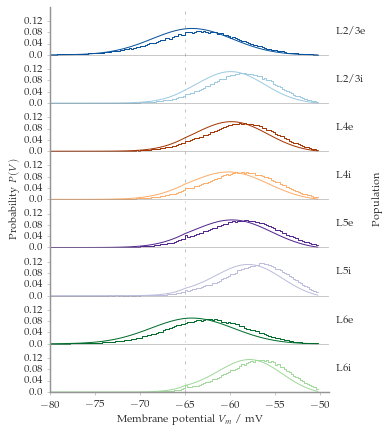

In [16]:
sim_spec = "membrane_potential"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

plot_membrane_potential(path_res_file, rate_mf, figname="membrane_potential")

# Simulated: fixed_indegree

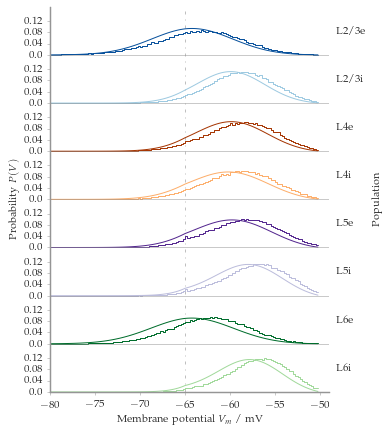

In [17]:
sim_spec = "membrane_potential_fixindeg"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

plot_membrane_potential(path_res_file, rate_mf, figname="membrane_potential_fixindeg")